In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/drive-digital-retinal-images-for-vessel-extraction")

print("Path to dataset files:", path)

100%|██████████| 28.0M/28.0M [00:00<00:00, 95.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/drive-digital-retinal-images-for-vessel-extraction/versions/1


In [47]:
import os
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from scipy.ndimage import gaussian_filter
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D


In [49]:
BASE_DIR = "/root/.cache/kagglehub/datasets/andrewmvd/drive-digital-retinal-images-for-vessel-extraction/versions/1"
IMAGE_DIR = os.path.join(BASE_DIR, "DRIVE", "training", "images")

files = sorted(os.listdir(IMAGE_DIR))

In [51]:
def load_image(path, size=(256, 256)):
    img = Image.open(path).convert("L")     # grayscale
    img = img.resize(size)
    img = np.array(img, dtype=np.float32) / 255.0
    return img

images = np.array([load_image(os.path.join(IMAGE_DIR, f)) for f in files])
images = images[..., np.newaxis]   # shape: (N, H, W, 1)


In [52]:
def add_gaussian_noise(imgs, sigma=0.15):
    noisy = imgs + np.random.normal(0, sigma, imgs.shape)
    return np.clip(noisy, 0, 1)

noisy_images = add_gaussian_noise(images)

In [55]:
X_train = noisy_images[:16]
Y_train = images[:16]

X_test = noisy_images[16:]
Y_test = images[16:]

model = Sequential([
    Conv2D(32, (3,3), activation="relu", padding="same", input_shape=(256,256,1)),
    Conv2D(32, (3,3), activation="relu", padding="same"),
    Conv2D(16, (3,3), activation="relu", padding="same"),
    Conv2D(1, (3,3), activation="sigmoid", padding="same")
])

model.compile(
    optimizer="adam",
    loss="mse"
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 256, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 256, 256, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 256, 256, 1)    │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,337 (56.00 KB)

 Trainable params: 14,337 (56.00 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
model.fit(
    X_train, Y_train,
    epochs=10,
    batch_size=2,
    validation_split=0.1,
    verbose=1
)


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 882ms/step - loss: 0.0773 - val_loss: 0.0646
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 718ms/step - loss: 0.0680 - val_loss: 0.0497
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 888ms/step - loss: 0.0462 - val_loss: 0.0194
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 996ms/step - loss: 0.0160 - val_loss: 0.0051
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 796ms/step - loss: 0.0058 - val_loss: 0.0067
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 615ms/step - loss: 0.0054 - val_loss: 0.0041
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 707ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 693ms/step - loss: 0.0039 - val_loss: 0.0028
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 885ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 625ms/step - loss: 0.0023 - val_loss: 0.0021


In [57]:
cnn_out = model.predict(X_test)
gaussian_out = np.array([
    gaussian_filter(img.squeeze(), sigma=1)
    for img in X_test
])[..., np.newaxis]
def compute_metrics(clean, denoised):
    data_range = 1.0
    return {
        "PSNR": peak_signal_noise_ratio(clean, denoised, data_range=data_range),
        "SSIM": structural_similarity(
            clean.squeeze(),
            denoised.squeeze(),
            data_range=data_range
        )
    }

print("Gaussian:", compute_metrics(Y_test[0], gaussian_out[0]))
print("CNN:", compute_metrics(Y_test[0], cnn_out[0]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
Gaussian: {'PSNR': np.float64(26.129139961632795), 'SSIM': np.float64(0.4919142500727847)}
CNN: {'PSNR': np.float64(26.74144196218287), 'SSIM': np.float64(0.6592263615966895)}


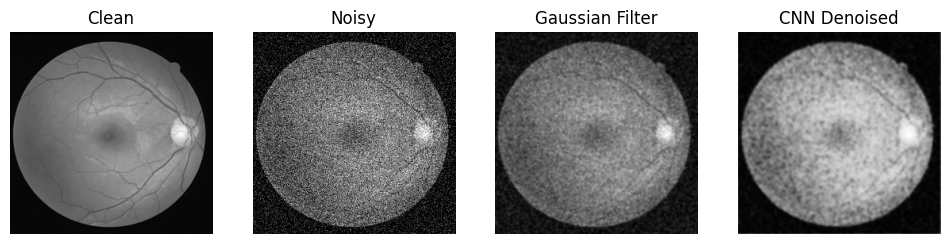

In [58]:
plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.imshow(Y_test[0].squeeze(), cmap="gray")
plt.title("Clean")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(X_test[0].squeeze(), cmap="gray")
plt.title("Noisy")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(gaussian_out[0].squeeze(), cmap="gray")
plt.title("Gaussian Filter")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(cnn_out[0].squeeze(), cmap="gray")
plt.title("CNN Denoised")
plt.axis("off")

plt.show()
